Прежде всего, импортнем и настроим все необходимое

In [26]:
from tqdm import tqdm
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.common.exceptions import NoSuchElementException
import chromedriver_binary 
import urllib
import time
from selenium.webdriver.common.keys import Keys
import lxml
import requests
import base64
import json
import pandas as pd
import numpy as np
import urllib.request
from fake_useragent import UserAgent
from bs4 import BeautifulSoup 
from selenium.webdriver.common.action_chains  import ActionChains

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

# Аналитика региональных музыкальных чартов на основе данных со стриминговой платформы Spotify

### Авторы: 
- Ковырков Денис (БЭК201)
- Безуглый Александр (БЭК201)
- Потапов Иван (БЭК201)

### Гипотезы

### План
#### 1. Сбор данных со Spotify
- a) Получить ссылки на плейлисты с региональными чартами
- б) Для каждого плейлиста собрать данные о позициях песен и количестве прослушиваний
- в) Для каждой песни из полученного списка собрать дополнительную информацию

#### 2. Обработка полученных данных
- а) Поиск пропущенных значений
- б) Создание таблицы без пропусков

#### 3. Получение производных значений
- а) Средневзвешенные значения для каждого региона по параметрам песен и количеству прослушиваний
- б) Взвешенные значения для жанров

#### 4. Визуализация таблиц
#### 5. Выводы

## Часть первая. Парсинг.

Прежде чем приступать к получению сведений о прослушиваниях, чартах и параметров композиций, стоит выбрать, с чего начинать. Итак, отправной точкой стала [страница](https://open.spotify.com/genre/charts-regional-weekly), содержащая в себе 53 плейлиста с еженедельными музыкальными топами: 1 мировой и 52 региональных. Штош, попробуем достать ссылки на все плейлисты через код элемента страницы. 


In [27]:
mainpage = requests.get("https://open.spotify.com/genre/charts-regional-weekly")
mainpage = BeautifulSoup(mainpage.content, 'html.parser')

Если попытаться вывести mainpage, то мы увидим ужасно некрасивый код html, который к тому же мало похож на то, что показывается при посещении страницы с использованием инструментов разработчика. А значит в этом коде не получится ориентироваться по тегам и классам. Ситуация не меняется даже если использовать fake useragent. Видимо, спотифай просто так не поддастся. 

Далее следует одна из самых сложных и в то же время самых интересных частей: с помощью библиотеки Selenium мы пытаемся обмануть сервис и притвориться человеком, чтобы получить нормальный код. Процесс парсинга занимает какое-то время, но это не сильно страшно, посколько нужно получить код только одной странцы. Интересный момент: Spotify не позволяет осуществлять просто прокрутить страницу методом скролла __driver.execute_script("window.scrollTo(0, Y)")__, поэтому мы программно наводим мышь на ползунок и двигаем его вниз, а потом еще пару раз нажимаем end(который тоже не работал бы без клика на ползунок). Это нужно для того, чтобы страница полностью прогрузилась и мы смогли получить айдишники всех плейлистов.

In [28]:
site = "https://open.spotify.com/genre/charts-regional-weekly"

#настраиваем селениум
driver = webdriver.Chrome('D:\chromedriver.exe') #выбираем расположение хромдрайвера на компьютере

#открываем сайт, двигаем мышку и кликаем, чтобы потом заработала прокрутка
driver.get(site)
driver.maximize_window()
time.sleep(3)
ActionChains(driver).move_by_offset(1520, 350).click().perform() #у дениса 1520 350
time.sleep(3)
driver.find_element_by_xpath('//body').send_keys(Keys.END) 
time.sleep(3)
driver.find_element_by_xpath('//body').send_keys(Keys.END) #моя добавка
time.sleep(3)

#получаем код страницы и делаем суп
response = driver.page_source
driver.close()

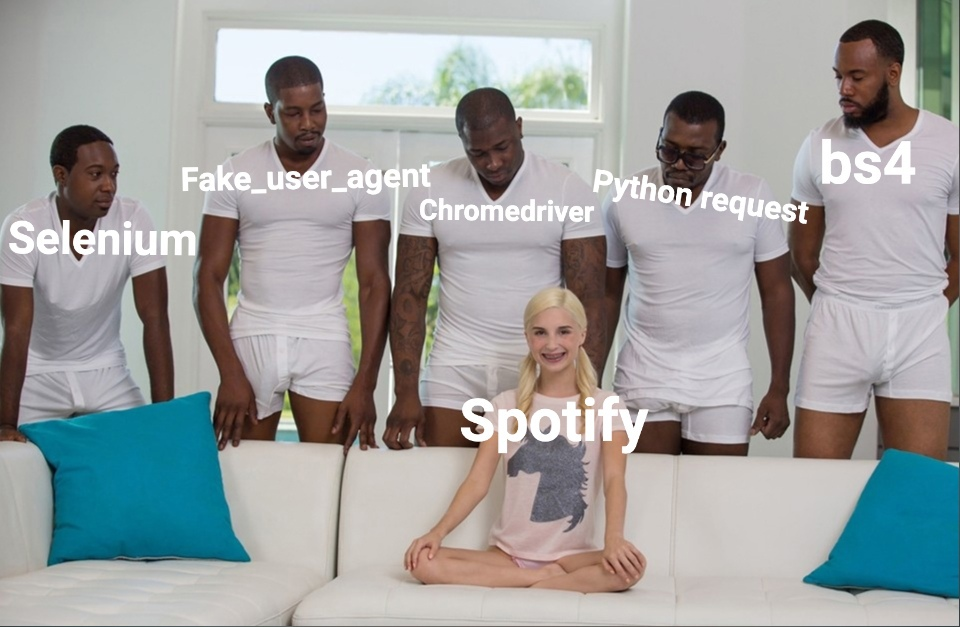

Когда код страницы успешло получен, осталось только сварить суп и составить таблицу с id-номерами плейлистов и сохранить в DataFrame-таблицу.


In [29]:
tree = BeautifulSoup(response, 'html.parser')

#С помощью браузера смотрим, к какому классу относятся нужные нам ссылки, и отбираем их
a = tree.find_all('a', class_ = 'f7ebc3d96230ee12a84a9b0b4b81bb8f-scss')

#из блоков с ссылками достаем айдишники плейлистов
ids = []
for i in a:
    id = i.get('href')
    ids.append(id[10:])
    
# ids это список айдишников для всех плейлистов из подборки. Потом айди можно будет вставлять в ссылки,
# и переходить на страницу каждого плейлиста.

In [42]:
#Для примера выведем один айдишник
ids[0]

'37i9dQZEVXbNG2KDcFcKOF'

Последние пять букв этого айди дают ясно понять, что спотифай нам не рад

Теперь приступаем к сбору информации о чартах в каждом плейлисте. Итак, как минимум, нам нужны: прослушивания, позиция в чарте, id-номер, название и регион. Забегая вперед, скажем, что методы API не возвращают количество стримов(а они критически важны для проекта) поэтому здесь мы так же вопспользуемся библиотекой Selenium.

Так же далее мы начинаем использовать методы API, поэтому следует произвести настройку доступа. Вот ссылки на страницы, которые сильно помогли это сделать, а так же в принципе разобраться с самими методами:

- [Официальный гайд по настройке доступа к методам](https://developer.spotify.com/documentation/web-api/quick-start/)
- [Чувак  рассказывает, как решить пробелему с кодировкой токена](https://dev.to/mxdws/using-python-with-the-spotify-api-1d02)
- [Официальная документация Spotify по методам](https://developer.spotify.com/documentation/web-api/reference/)

In [30]:
# Подготовка к работе с API, авторизируемся на сайте и изменяем кодировку для получения токена доступа
url = "https://accounts.spotify.com/api/token"
headers = {}
data = {}

message = f"{'3e661d7345d04909b518ec04ec996fd2'}:{'c3ce130028654a779d6404a619845bd6'}"
messageBytes = message.encode('ascii')
base64Bytes = base64.b64encode(messageBytes)
base64Message = base64Bytes.decode('ascii')

headers['Authorization'] = f"Basic {base64Message}"
data['grant_type'] = "client_credentials"

r = requests.post(url, headers=headers, data=data)

token = r.json()['access_token']

#### Функция по получению списка песен, их места в топе, прослушиваний и т.д.  для каждого плейлиста 

In [31]:
def get_MainInfo(playlist_id):
    #создаем часть таблицы (место в топе в качестве индекса, имена и id песен, сама функция в следующей клетке)
    MainInfo = mini_get_playlist(playlist_id)[['song_name', 'song_id']]
    
    #парсим код страницы альбома с испльзованием селениума
    site = "https://open.spotify.com/playlist/" + playlist_id
    chrome_options = Options()
    driver = webdriver.Chrome(options=chrome_options)
    driver.get(site)
    time.sleep(3)
    response = driver.page_source
    driver.close()
    tree = BeautifulSoup(response, 'html.parser')
    
    #ищем все куски кода, где написаны просмотры
    a = tree.find_all('div', class_ = 'd47b790d001ed769adcd9ddfc0e83acc-scss f3fc214b257ae2f1d43d4c594a94497f-scss')
    
    #из них получаем строки с прослушиваниями и обрабатываем их
    res = []
    b = list(a)
    for i in b:
        views = str(i)[-16:-6].replace('\xa0', '')
        res.append(views)
    #res - список прослушиваний от топа ко дну (неформатированный)
    #вытащим из элементов res только числа
    views = []
    for i in res:
        ddd = [s for s in i.split('>') if s.isdigit()]
        views.append(int(ddd[0]))
    #views - просмотры по порядку для каждой песни из топа
    #добавляем колонки с просмотрами, местом в топе и страной к существующей таблице
    MainInfo.insert(2, "views", views)
    MainInfo.insert(0, "place", range(1,51))
    MainInfo.insert(0, "country", playlist_info(playlist_id)[1])
    return MainInfo

#### Мини-версии функций по получению информации о треках в одном плейлисте

В качестве параметра указывается id-номер плейлиста, на выход - Df таблица с названиями и id каждой песни.

In [32]:
def mini_get_playlist(playlist_id):
    playlistUrl = f'https://api.spotify.com/v1/playlists/{playlist_id}/tracks'
    headers = {
        "Authorization": "Bearer " + token
    }
    
    page = requests.get(url=playlistUrl, headers=headers)
    page =  page.json()
    page = mini_playlist_req_to_list(page)    
    return page

In [33]:
def mini_playlist_req_to_list(file):

    song_name = [None for i in range(50)]
    song_id = [None for i in range(50)]
      
    i = 0
    
    for item in file['items']:        
        song_name[i] = item['track']['name']
        song_id[i] = item['track']['id']
        
        i += 1
        
    data_dict = {'song_name' : song_name, 'song_id' : song_id}
    data_set = pd.DataFrame(data_dict)
    
    return data_set

#### Раз уж на то пошло, сразу посмотрим на полную версию функций по получению сведений о песнях в плейлисте

Главной функцией является __get_playlist__, на вход подается id-номер плейлиста, результат - df таблица со сведениями, которые будут описаны ниже. [Метод API](https://developer.spotify.com/documentation/web-api/reference/#category-playlists) позволяет достать соответствующую информацию.

Внутренние функции:

- __song_paramets__ - получает айдишник песни, с помощью [метода API](https://developer.spotify.com/documentation/web-api/reference/#category-tracks) выдает параметры _danceability, energy, key, loudness, mode, speechiness, acousticness, instrumentalness, liveness, valence, tempo_. Их интерпретация так же будет приведена ниже.
- __playlist_req_to_list__ - большая толстенькая функция. На вход принимает json-файл со сведениями о плейлисте, на выход - таблица с песнями, содержащая различные параметры, смысл которых интуитивно ясен, но все равно будет раскрыт далее.

In [34]:
def get_playlist(playlist_id):
    playlistUrl = f'https://api.spotify.com/v1/playlists/{playlist_id}/tracks'
    headers = {
        "Authorization": "Bearer " + token
    }
    
    page = requests.get(url=playlistUrl, headers=headers)
    page =  page.json()
    page = playlist_req_to_list (page)    
    return page

def playlist_req_to_list(file):

    song_name = [None for i in range(50)]
    song_id = [None for i in range(50)]
    duration = [None for i in range(50)]
    artist_name = [None for i in range(50)]
    artist_id = [None for i in range(50)]
    album_name = [None for i in range(50)]
    album_id = [None for i in range(50)]
    release_date = [None for i in range(50)]
    local_position = [None for i in range(50)]
    world_position = [None for i in range(50)]
    danceability = [None for i in range(50)]
    energy = [None for i in range(50)]
    key = [None for i in range(50)]
    loudness = [None for i in range(50)]
    mode = [None for i in range(50)]
    speechiness = [None for i in range(50)]
    acousticness = [None for i in range(50)]
    instrumentalness = [None for i in range(50)]
    liveness = [None for i in range(50)]
    valence = [None for i in range(50)]
    tempo = [None for i in range(50)]
      
    i = 0
    
    for item in file['items']:        
        song_name[i] = item['track']['name']
        song_id[i] = item['track']['id']
        duration[i] = item['track']['duration_ms']
        local_position[i] = item['track']['popularity']       
        artist_name[i] = item['track']['album']['artists'][0]['name']
        artist_id[i] = item['track']['album']['artists'][0]['id']
        album_name[i] = item['track']['album']['name']
        album_id[i] = item['track']['album']['id']
        release_date[i] = item['track']['album']['release_date']
        
        parametrs = song_paramets(song_id[i])
        
        danceability[i] = parametrs['danceability']
        energy[i] = parametrs['energy']
        key[i] = parametrs['key']
        loudness[i] = parametrs['loudness']
        mode[i] = parametrs['mode']
        speechiness[i] = parametrs['speechiness']
        acousticness[i] = parametrs['acousticness']
        instrumentalness[i] = parametrs['instrumentalness']
        liveness[i] = parametrs['liveness']
        valence[i] = parametrs['valence']
        tempo[i] = parametrs['tempo']
        
        i += 1
        
    data_dict = {'song_name' : song_name,
                 'song_id' : song_id,
                 'duration_ms' : duration,
                 'local_position' : local_position,
                 'artist_name' : artist_name,
                 'artist_id' : artist_id,
                 'album_name' : album_name,
                 'album_id' : album_id,
                 'release_date' : release_date,
                 'danceability': danceability,
                 'energy': energy,
                 'key': key,
                 'loudness': loudness,
                 'mode': mode,
                 'speechiness': speechiness,
                 'acousticness': acousticness,
                 'instrumentalness': instrumentalness,
                 'liveness': liveness,
                 'valence': valence,
                 'tempo': tempo
                }
    data_set = pd.DataFrame(data_dict)
    
    return data_set

def song_paramets(song_id):
    
    song_url = f'https://api.spotify.com/v1/audio-features/{song_id}'
    headers = {
        "Authorization": "Bearer " + token
    }

    page = requests.get(url=song_url, headers=headers)
    page =  page.json()
    return page

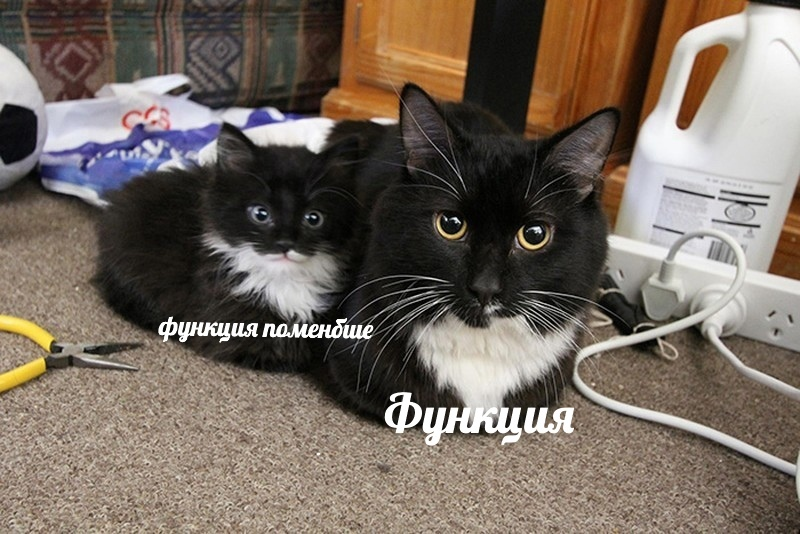

Еще одна небольшая функция, которая для каждой песни через [метод API](https://developer.spotify.com/documentation/web-api/reference/#category-artists) получает жанры для артиста. Решение приравнять жанр композиции к жанру, в котором пишет ее автор, в какой-то степени опрометчиво, однако мы решили, что это лучше, чем ничего, а сами данные могут оказаться полезными.

In [35]:
def get_genres(artists):
    result = []
    for i in tqdm(artists):
        id = i
        playlistUrl = f'https://api.spotify.com/v1/artists/{id}'
        headers = {"Authorization": "Bearer " + token}
        page = requests.get(url=playlistUrl, headers=headers)
        page = page.json()
        genres = page['genres']
        result.append(genres)
    return result

И, наконец, функция для получения инфы о плейлисте через api

In [36]:
def playlist_info(playlist_id):
    playlistUrl = f'https://api.spotify.com/v1/playlists/{playlist_id}'
    headers = {
        "Authorization": "Bearer " + token
    }
    
    page = requests.get(url=playlistUrl, headers=headers)
    page =  page.json()
    text = page['description']
    number = page['followers']['total']
    country = text[text.find('now -')+6:-1]
    info = [playlist_id,country,number]
    return info

## Собираем дата-сеты

### Маленький датасетик вида (айди листа, страна, кол-во подписчиков)

Структура:

- __country__ - название региона для плейлиста

- __id__ - id-номер плейлиста

- __followers__ - количество подписчиков

Название в репозитории - __countries 2.csv__

Размер - __53 х 3__

In [37]:
countries = pd.DataFrame(playlist_info(item) for item in ids)
countries.columns= ['id', 'country', 'followers'] 
countries = countries.set_index('country')

### Датасет побольше (данные о каждой песне, включая ее акустические характеристики)

#### Структура таблицы:

- __song_name__ - название песни на английском языке
- __song_id__ - уникальный id-номер трека, по которому можно обращаться через API
- __duration__ - длительность трека в миллисекундах 
- __artist_name__ - имя исполнителя на английском языке
- __artist_id__ - уникальный id-номер артиста, по которому можно обращаться через API
- __album_name__ - название альбома на английском языке
- __album_id__ - уникальный id-номер альбома, по которому можно обращаться через API
- __local_position__ - позиция в локальном чарте
- __release_date__ - дата выхода песни

- __danceability__ - Танцевальность описывает, насколько подходит трек для танцев, основанный на сочетании музыкальных элементов, включая темп, стабильность ритма, силу ритма и общую регулярность. Значение 0.0 является наименее танцевальным, а 1.0 - наиболее танцевальным;

- __energy__ - Энергия-это мера от 0,0 до 1,0 и представляет собой перцептивную меру интенсивности и активности. Как правило, энергичные треки кажутся быстрыми, громкими и шумными. Например, death-metal обладает высокой энергией, в то время как прелюдия Баха набирает низкие баллы по шкале. Особенности восприятия, способствующие этому атрибуту, включают динамический диапазон, воспринимаемую громкость, тембр, частоту начала и общую энтропию;

- __key__ - Тональность, в котором находится трек. Целые числа сопоставляются с шагами, используя [стандартную нотацию](https://ru.wikipedia.org/wiki/Высотный_класс)  класса шага, например, 0 = C, 1 = C♯/D♭, 2 = D и так далее;

- __loudness__ - Общая громкость трека в децибелах (дБ). Значения громкости усредняются по всей дорожке и полезны для сравнения относительной громкости дорожек. Громкость-это качество звука, которое является основным психологическим коррелятом физической силы (амплитуды). Значения обычно находятся в диапазоне от -60 до 0 дБ;

- __mode__ - Режим указывает на модальность (мажорную или минорную) трека, тип шкалы, из которой извлекается его мелодическое содержание. Мажор представлен 1, а минор-0;

- __speechiness__ - Обнаруживает присутствие произнесенных слов в треке. Чем более исключительно речевая запись (например, ток-шоу, аудиокнига, стихи), тем ближе к 1.0 значение атрибута. Значения выше 0,66 описывают треки, которые, вероятно, полностью состоят из произнесенных слов. Значения от 0.33 до 0.66 описывают треки, которые могут содержать как музыку, так и речь, либо в разделах, либо слоями, включая такие случаи, как рэп-музыка. Значения ниже 0,33, скорее всего, представляют музыку и другие треки, не похожие на речь;

- __acousticness__ - Мера достоверности от 0,0 до 1,0 того, является ли дорожка акустической. 1.0 представляет собой высокую степень уверенности в том, что трек является акустическим;

- __instrumentalness__ - Предсказывает, не содержит ли трек вокала. Звуки “Ох” и “аах” в этом контексте рассматриваются как инструментальные. Рэп или разговорные треки явно “вокальные”. Чем ближе значение инструментальности к 1.0, тем больше вероятность того, что трек не содержит вокального контента. Значения выше 0,5 предназначены для представления инструментальных треков, но достоверность выше по мере приближения значения к 1,0;

- __liveness__ - Обнаруживает присутствие аудитории в записи. Более высокие значения живучести представляют собой повышенную вероятность того, что трек был выполнен вживую. Значение выше 0,8 обеспечивает высокую вероятность того, что трек находится в режиме реального времени;

- __valence__ - Мера от 0,0 до 1,0, описывающая музыкальную позитивность, передаваемую треком. Треки с высокой валентностью звучат более позитивно (например, счастливые, веселые, эйфоричные), в то время как треки с низкой валентностью звучат более негативно (например, грустные, подавленные, злые);

- __tempo__ - Общий расчетный темп трека в ударах в минуту (BPM). В музыкальной терминологии темп-это скорость или темп данного произведения, который напрямую зависит от средней продолжительности такта;

- __world_postion*__ - позиция в мировом чарте
- __local_streams__ - количество прослушиваний в регионе
- __world_streams__ - количесвтво прослушиваний в мире

Название в репозитории - __allsongs.csv__.

Размер - __1105 х 6__

In [45]:
allsongs=pd.DataFrame()
for item in tqdm(ids[:2]):
    allsongs=pd.concat([allsongs,get_playlist(item)],sort=False, axis=0, )

allsongs = allsongs.drop_duplicates(subset=['song_id'])
allsongs = allsongs.set_index('song_id')

#добавим инфу о жанрах в allsongs
artists = list(allsongs['artist_id'])
genres = get_genres(artists)
allsongs['genres'] = genres

100%|██████████████████████████████████████████████████████████████████████████████████| 66/66 [00:15<00:00,  4.20it/s]


### Датасет совсем большой че с ним (данные о позиции и прослушиваниях каждой песни в каждом топе)

#### Структура таблицы:

- __country__ - название региона
- __place__ - позиция трека в текущем плейлисте
- __song_id__ - уникальный id-номер трека
- __streams__ - количество прослушиваний

Название в репозитории - __positions 2.csv__


Размер - __2650 х 6__

In [43]:
positions = pd.DataFrame()
for id in tqdm(ids):
    country = get_MainInfo(id)
    positions = pd.concat([positions, country],sort=False, axis=0)
    
positions = positions.reset_index(drop = True)

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:34<00:00, 17.28s/it]


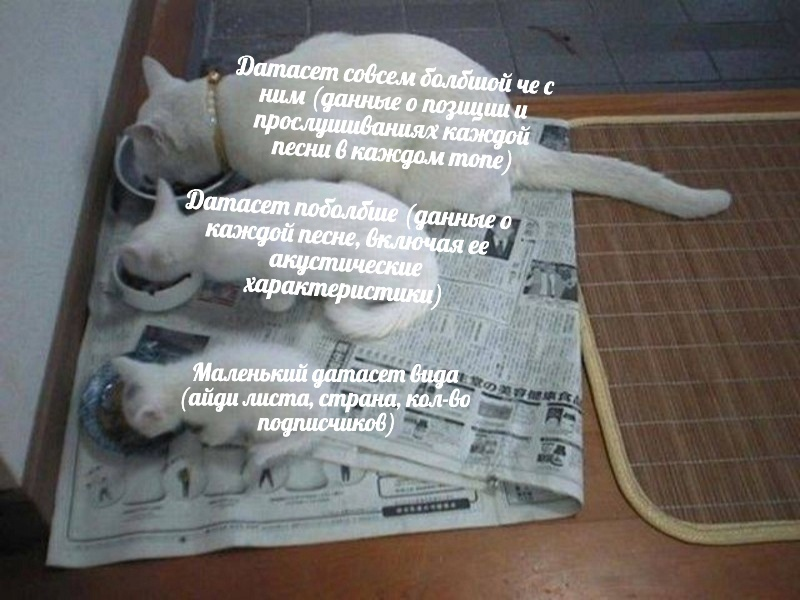